## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime

from datetime import datetime
from scipy.stats import normaltest
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("/kaggle/input/train/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


### Определите временные рамки (без учета времени), за которые представлены данные.

In [6]:
start = taxi_data['pickup_datetime'].dt.date.min()
stop = taxi_data['dropoff_datetime'].dt.date.max()
print(f'Временные рамки находятся между {start} и {stop}')

Временные рамки находятся между 2016-01-01 и 2016-07-01


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [7]:
print(taxi_data.isnull().sum()) #смотрим пропуски в DataFrame

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

### а) Сколько уникальных таксопарков присутствует в данных?

In [8]:
print('уникальных таксопарков:', taxi_data['vendor_id'].nunique())

уникальных таксопарков: 2


### б) Каково максимальное количество пассажиров?

In [9]:
print(' максимальное количество пассажиров:', taxi_data['passenger_count'].max())

 максимальное количество пассажиров: 9


### в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

In [10]:
print(' средняя длительность поездки:', round(taxi_data['trip_duration'].mean(),0), 'c.,', 'медианная длительность поездки:', round(taxi_data['trip_duration'].median(),0), 'c.')

 средняя длительность поездки: 959.0 c., медианная длительность поездки: 662.0 c.


### г) Чему равно минимальное и максимальное время поездки (в секундах)?

In [11]:
print(' минимальное время поездки:', round(taxi_data['trip_duration'].min(),0), 'c.,', 'максимальное время поездки:', round(taxi_data['trip_duration'].max(),0), 'c.') 

 минимальное время поездки: 1 c., максимальное время поездки: 3526282 c.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.


In [12]:
      # Код рабочий
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data

In [13]:
taxi_data=add_datetime_features(taxi_data)
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


In [14]:
# taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.date
# taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
# taxi_data['pickup_day_of_week'] =taxi_data['pickup_datetime'].dt.day_name()
# taxi_data

In [15]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

### а) Сколько поездок было совершено в субботу?


In [16]:
trip_sat=taxi_data['pickup_day_of_week'].value_counts()['Saturday']
print(f'В субботу было совершено {trip_sat} поездок')

В субботу было совершено 220868 поездок


### б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [17]:
trip_mean = round(len(taxi_data['pickup_date'])/len(taxi_data['pickup_date'].value_counts()),0)
print(f'В среднем совершается {trip_mean} поездок в день')

В среднем совершается 8015.0 поездок в день


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [18]:
holiday_data = pd.read_csv('/kaggle/input/holiday-usa-2016/holiday_data_USA_2016.csv', sep=';')
holiday_data['DATE'] = pd.to_datetime(holiday_data['DATE'], format='%Y-%m-%d')
holiday_data

,DAY,DATE,HOLIDAY
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,M L King Day
2,Friday,2016-02-12,Lincolns Birthday
3,Monday,2016-02-15,Presidents Day
4,Sunday,2016-05-08,Mothers Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Fathers Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


In [19]:
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DAY      14 non-null     object        
 1   DATE     14 non-null     datetime64[ns]
 2   HOLIDAY  14 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 464.0+ bytes


In [20]:
def add_holiday_features(taxi_df, holiday_df):
    taxi_df['pickup_date'] = pd.to_datetime(taxi_df['pickup_date'], format='%Y-%m-%d') #Преобразуем в формат Date
    holiday_df['DATE'] = pd.to_datetime(holiday_df['DATE'], format='%Y-%m-%d') #Преобразуем в формат Date
    merged_df = taxi_df.join(holiday_df.set_index('DATE'), on='pickup_date', how='left') #Объединим DataFrames
    merged_df = merged_df.rename(columns={"HOLIDAY": "pickup_holiday"}) # Переименуем столбец
    merged_df = merged_df.drop(['DAY'], axis=1) # Удалим столбец DAY
    merged_df["pickup_holiday"] = merged_df["pickup_holiday"].fillna(0) # Произведём замену NAN на 0 в столбце pickup_holiday
    merged_df["pickup_holiday"].loc[merged_df["pickup_holiday"] != 0] = 1
    
    return merged_df

In [21]:
taxi_data_hl = add_holiday_features(taxi_data, holiday_data)
taxi_data_hl.tail()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,2016-04-05,14,Tuesday,0


In [22]:
df_pickup_holiday = taxi_data_hl[taxi_data_hl['pickup_holiday'] == 1] # Сгруппируем данные
med_trip = df_pickup_holiday['trip_duration'].median() # Найдем медианное значение
print(f'Медианная длительность поездки на такси в праздничные дни {med_trip} c.')

Медианная длительность поездки на такси в праздничные дни 585.0 c.


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [23]:
osrm_data = pd.read_csv('/kaggle/input/osrm-data-train/osrm_data_train.csv')
osrm_data.tail()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
1458638,id2976426,Cargo Plaza,East 51st Street,28051.1,1462.5,13,Cargo Plaza|Cargo Plaza|Van Wyck Expressway|Ca...,145.4|1039|12154.4|931.8|6422.3|3745.6|2032.5|...,21|82.8|489.4|57.2|359.5|164.1|139.9|14.4|2.9|...,depart|on ramp|new name|off ramp|merge|fork|ne...,right|slight right|straight|slight right|sligh...,"-73.78445,40.648461|-73.785844,40.647851|-73.7..."
1458639,id1440046,Former Terminal 6 Departures,3rd Avenue,29616.3,1643.2,16,Former Terminal 6 Departures|Cargo Plaza|Cargo...,110.2|415.2|895.1|12154.4|931.8|6422.3|1686.5|...,15.9|63.9|71.6|489.4|57.2|359.5|81.8|19.4|10.3...,depart|fork|on ramp|new name|off ramp|merge|fo...,right|slight left|straight|straight|slight rig...,"-73.779336,40.647005|-73.780349,40.64763|-73.7..."
1458640,id1607338,Cargo Plaza,West 8th Street,25615.0,1765.1,30,Cargo Plaza|Cargo Plaza|Cargo Plaza|Cargo Plaz...,179.5|66.3|314.8|431.8|1557.5|266.3|454.7|604|...,28|9.5|25.2|34.5|62|21.3|36.6|24.1|25.2|238.2|...,depart|fork|on ramp|fork|new name|off ramp|for...,none|slight right|straight|slight left|straigh...,"-73.786697,40.641627|-73.78622,40.643052|-73.7..."
1458641,id2071901,Cargo Plaza,Laurel Hill Boulevard,20284.1,1074.3,14,Cargo Plaza|Cargo Plaza|Cargo Plaza|Van Wyck E...,124.3|535.2|895.1|12154.4|931.8|1521.6|573.1|3...,22|79|71.6|489.4|57.2|85.4|45.9|28.5|22.2|9.5|...,depart|fork|fork|new name|off ramp|merge|off r...,right|straight|slight left|straight|slight rig...,"-73.782317,40.644873|-73.780877,40.645095|-73...."
1458642,id0995846,Terminal 8 departures,West 106th Street,30302.5,1675.8,20,Terminal 8 departures|Cargo Plaza|Cargo Plaza|...,493.4|436.6|238.9|8759.3|703.1|3806.4|5006.7|1...,73|64.8|19|350|56.3|152.4|200.6|115.1|81.1|179...,depart|fork|on ramp|new name|off ramp|merge|fo...,right|slight right|straight|straight|slight le...,"-73.789512,40.647057|-73.788279,40.645582|-73...."


In [24]:
def add_osrm_features(taxi_df, osrm_df):

    geo_df = taxi_df.join(osrm_df.set_index('id')[['total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left') #Объединим DataFrames
 
    return geo_df



In [25]:
taxi_data_geo = add_osrm_features(taxi_data_hl, osrm_data)
taxi_data_geo.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0,2234.6,311.7,8.0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0,7638.0,589.6,11.0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0,9871.5,642.9,10.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,2016-04-05,14,Tuesday,0,1134.2,90.7,2.0


### а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

In [26]:
R=taxi_data_geo['trip_duration'].median() - taxi_data_geo['total_travel_time'].median()
print(f'а) Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки {round(R,0)} c.')

а) Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки 372.0 c.


В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

### б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [27]:
omissions=taxi_data_geo.shape[0] - taxi_data_geo.dropna().shape[0]
print(f'б) Количество пропусков в столбцах: {omissions}')

б) Количество пропусков в столбцах: 1


In [28]:
def get_haversine_distance( lng1, lat1, lng2, lat2):
    # переводим углы в радианы
    lng1, lat1, lng2, lat2 = map(np.radians, (lng1, lat1, lng2, lat2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lng1, lat1, lng2, lat2):
    # переводим углы в радианы
    lng1, lat1, lng2, lat2 = map(np.radians, (lng1, lat1, lng2, lat2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [29]:
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(data['pickup_longitude'], data['pickup_latitude'], data['dropoff_longitude'], data['dropoff_latitude'])
    data['direction'] = get_angle_direction(data['pickup_longitude'], data['pickup_latitude'], data['dropoff_longitude'], data['dropoff_latitude'])
    
    return data



In [30]:
taxi_data_geo_feat = add_geographical_features(taxi_data_geo)
taxi_data_geo_feat.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0,2234.6,311.7,8.0,1.225080,-119.059338
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0,7638.0,589.6,11.0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0,9871.5,642.9,10.0,7.824606,-150.788492
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0,1.092564,35.033294
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,2016-04-05,14,Tuesday,0,1134.2,90.7,2.0,1.134042,29.969486


### Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.

In [31]:
hav_dist=taxi_data_geo_feat['haversine_distance'].median()
print(f'Медианное расстояние Хаверсина поездок {round(hav_dist, 2)} км.')

Медианное расстояние Хаверсина поездок 2.09 км.


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [32]:
# создаем обучающую выборку из географических координат всех точек
#coords = np.hstack((taxi_data_geo_feat[['pickup_latitude', 'pickup_longitude']],
#                    taxi_data_geo_feat[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
#kmeans = cluster.KMeans(n_clusters=10, random_state=42)
#kmeans.fit(coords)

In [33]:
def add_cluster_features(taxi_df):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    taxi_df['geo_cluster'] = kmeans.predict(coords)
    return taxi_df




In [34]:
taxi_geocl = add_cluster_features(taxi_data_geo_feat)

In [99]:
taxi_geocl

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2016-04-08,13,Friday,0,2234.6,311.7,8.0,1.225080,-119.059338,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2016-01-10,7,Sunday,0,7638.0,589.6,11.0,6.049836,25.342196,9
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2016-04-22,6,Friday,0,9871.5,642.9,10.0,7.824606,-150.788492,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0,1.092564,35.033294,0


### Сколько поездок содержится в наименьшем по размеру географическом кластере?

In [35]:
min_trip=taxi_geocl['geo_cluster'].value_counts().min()
print(f'в наименьшем по размеру географическом кластере содержится {min_trip} поездки')

в наименьшем по размеру географическом кластере содержится 2 поездки


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [36]:
weather_data = pd.read_csv('/kaggle/input/weather/weather_data.csv')

In [37]:
weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6


In [38]:
taxi_geocl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

In [39]:
def add_weather_features(df, weather_df):
    weather_data['time'] = pd.to_datetime(weather_data['time'])
    weather_data['date'] = pd.to_datetime(weather_data['date'])
    weather_data['hour'] = weather_data['time'].dt.hour
    
    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]

    df = df.merge(
        weather_data[weather_columns], 
        left_on=['pickup_date', 'pickup_hour'], 
        right_on=['date', 'hour'],
        how='left'
    ) 
    df = df.drop(['date', 'hour'], axis=1)
    return df



In [40]:
taxi_data_wth = add_weather_features(taxi_geocl, weather_data)
taxi_data_wth

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,9,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,4,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


### а) Сколько поездок было совершено в снежную погоду?

In [41]:
snow_day = taxi_data_wth[taxi_data_wth['events'] == 'Snow'].shape[0]
print(f'в снежную погоду было совершено {snow_day} поездок')

в снежную погоду было совершено 13126 поездок


В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

### б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.

In [42]:
NaN_s = len(taxi_data_wth)-taxi_data_wth['events'].count() # считаем количество пропусков в столбце
prop_n = NaN_s / len(taxi_data_wth)*100
print(f'пропуски в столбцах с погодными условиями занимают {round(prop_n,2)} %')


пропуски в столбцах с погодными условиями занимают 0.82 %


## Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

In [43]:
def fill_null_weather_data(taxi_df):
    col = ['temperature', 'visibility', 'wind speed', 'precip']
    taxi_df[col] = taxi_df[col].fillna(taxi_df.groupby('pickup_date')[col].transform('median'))
    taxi_df['events'] = taxi_df['events'].fillna('None')
    taxi_df['total_distance'] = taxi_df['total_distance'].fillna(taxi_df['total_distance'].median(skipna=True))
    taxi_df['total_travel_time'] = taxi_df['total_travel_time'].fillna(taxi_df['total_travel_time'].median(skipna=True))
    taxi_df['number_of_steps'] = taxi_df['number_of_steps'].fillna(taxi_df['number_of_steps'].median(skipna=True))
    return taxi_df


In [44]:
taxi_fill = fill_null_weather_data(taxi_data_wth)
taxi_fill.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


### Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.

In [45]:
temp = taxi_fill['temperature'].median()
print(f'медианная температура в столбце temperature равна {temp} градусов')

медианная температура в столбце temperature равна 11.1 градусов


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


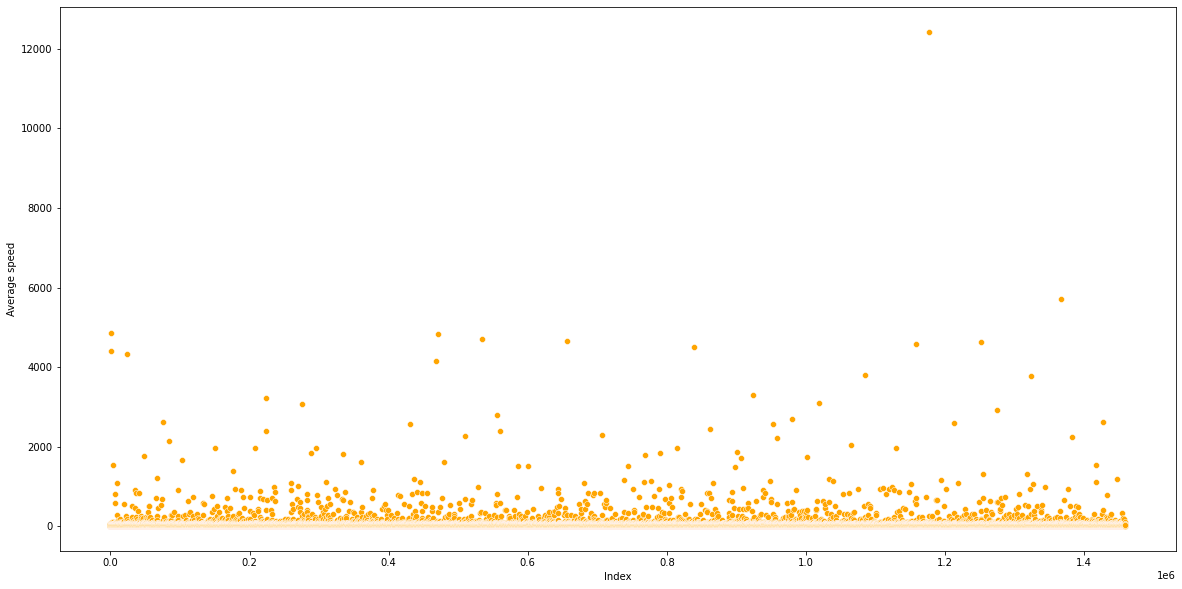

In [46]:
avg_speed = taxi_data_wth['total_distance'] / taxi_data_wth['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(20, 10))
plt.style.use('dark_background')
sns.scatterplot(x=avg_speed.index, color='orange', y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

### а) Сколько выбросов по признаку длительности поездки вам удалось найти?

In [47]:
trip_dur = taxi_data_wth[(taxi_data_wth['trip_duration']>86400)]
print(f'количество выбросов по признаку длительности поездки: {trip_dur.shape[0]}')

количество выбросов по признаку длительности поездки: 4


Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

### б) Сколько выбросов по признаку скорости вам удалось найти?

In [48]:
avg_sp = taxi_data_wth[((taxi_data_wth['total_distance'] / taxi_data_wth['trip_duration'] * 3.6) >=300)]
print(f'количество выбросов по признаку скорости: {avg_sp.shape[0]}')

количество выбросов по признаку скорости: 407


### Удаляем выбросы

In [49]:
taxi_data = taxi_data_wth.drop(trip_dur.index, axis=0)
taxi_data = taxi_data_wth.drop(avg_sp.index, axis=0)

### Проверим 

In [50]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458237 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458237 non-null  object        
 1   vendor_id           1458237 non-null  int64         
 2   pickup_datetime     1458237 non-null  datetime64[ns]
 3   dropoff_datetime    1458237 non-null  datetime64[ns]
 4   passenger_count     1458237 non-null  int64         
 5   pickup_longitude    1458237 non-null  float64       
 6   pickup_latitude     1458237 non-null  float64       
 7   dropoff_longitude   1458237 non-null  float64       
 8   dropoff_latitude    1458237 non-null  float64       
 9   store_and_fwd_flag  1458237 non-null  object        
 10  trip_duration       1458237 non-null  int64         
 11  pickup_date         1458237 non-null  datetime64[ns]
 12  pickup_hour         1458237 non-null  int64         
 13  pickup_day_o

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [51]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Проведём первичный осмотр набора данных, просмотрим свойства признаков, проведем числовой и статистический однофакторный анализ

In [52]:
#pip install sweetviz

In [53]:
#import sweetviz as sv
#report = sv.analyze(taxi_data)

In [54]:
#report.show_html()

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


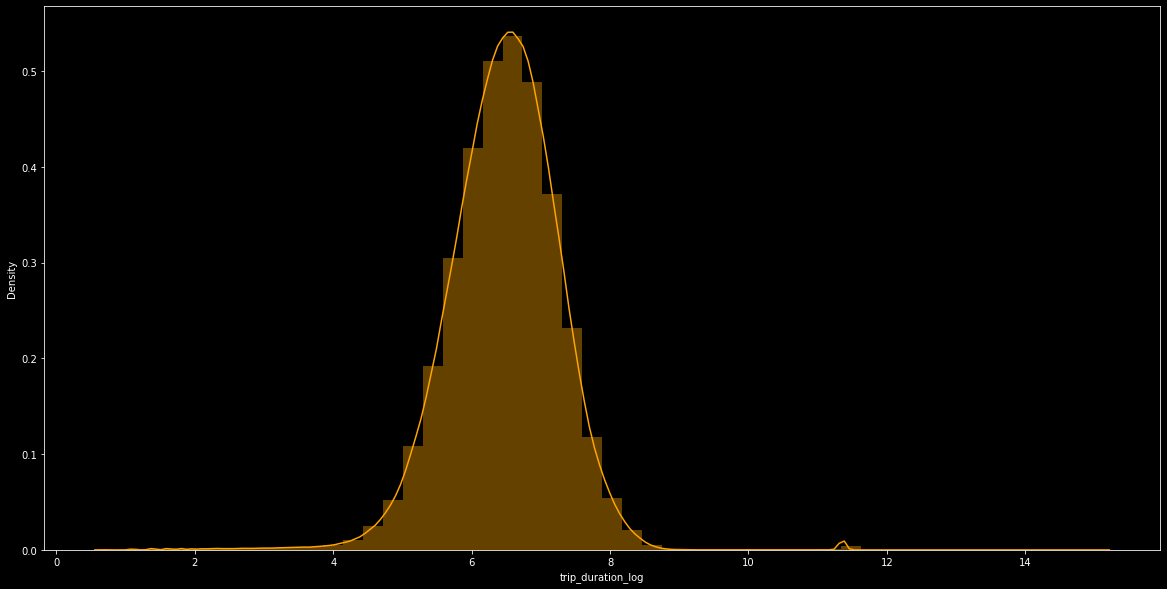

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.style.use('dark_background')
sns_plot = sns.distplot(taxi_data['trip_duration_log'], color='orange')
fig = sns_plot.get_figure()

### Вывод: полученное распределение не является нормальным

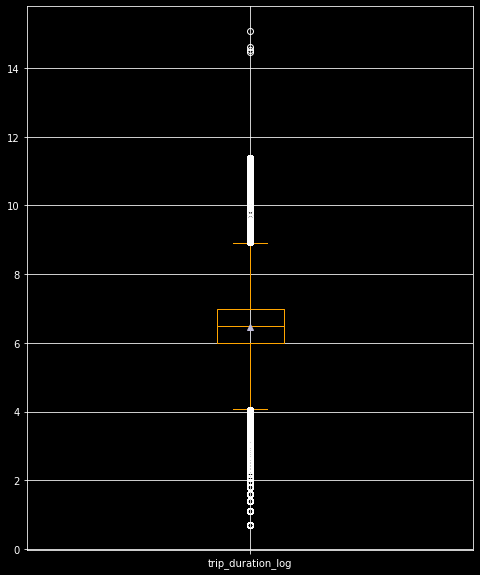

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10))
plt.style.use('dark_background')
pd.DataFrame(taxi_data['trip_duration_log']).boxplot(sym='o', whis=1.95, color='orange', showmeans=True)
plt.show()

### Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

In [57]:
stat, p = normaltest(taxi_data['trip_duration_log'])
alpha = 0.05

### а) Чему равен вычисленный p-value? Ответ округлите до сотых.

In [58]:
print('p-value = ', p)

p-value =  0.0


### б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

In [59]:
if p < alpha:  # проверка условия
    print("Данные не распределены нормально (мы отвергаем H0)")
else:
    print("Данные распределены нормально")

Данные не распределены нормально (мы отвергаем H0)


### Вывод: полученное распределение не является нормальным

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

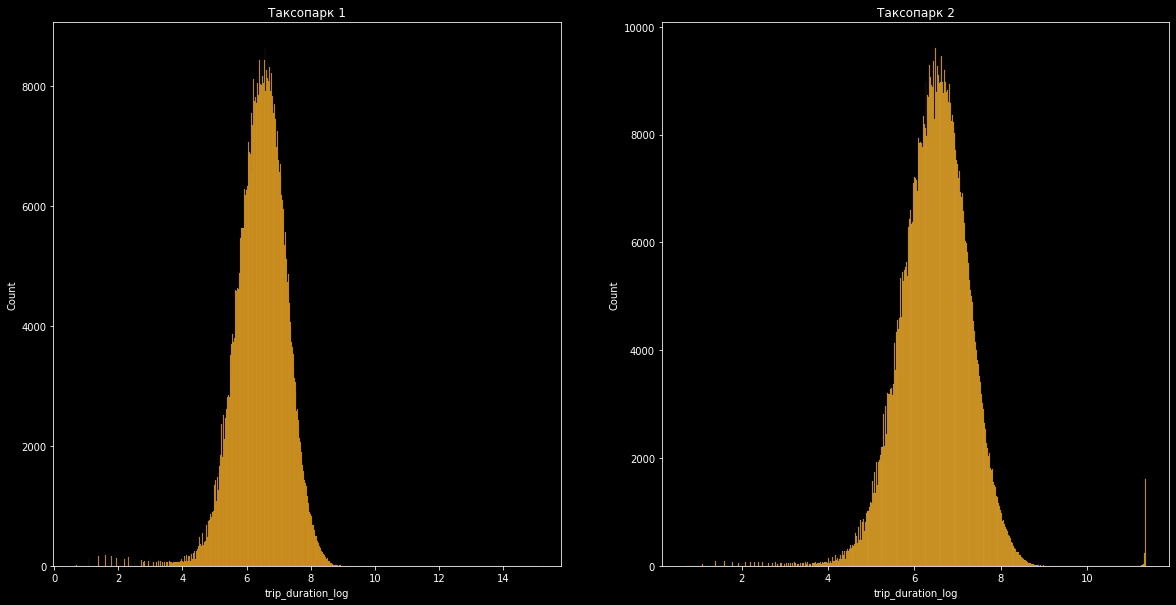

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plt.style.use('dark_background')
histplot = sns.histplot(data=taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log'],color='orange', ax=axes[0]);
histplot.set_title('Таксопарк 1');
histplot = sns.histplot(data=taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log'],color='orange', ax=axes[1]);
histplot.set_title('Таксопарк 2');

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

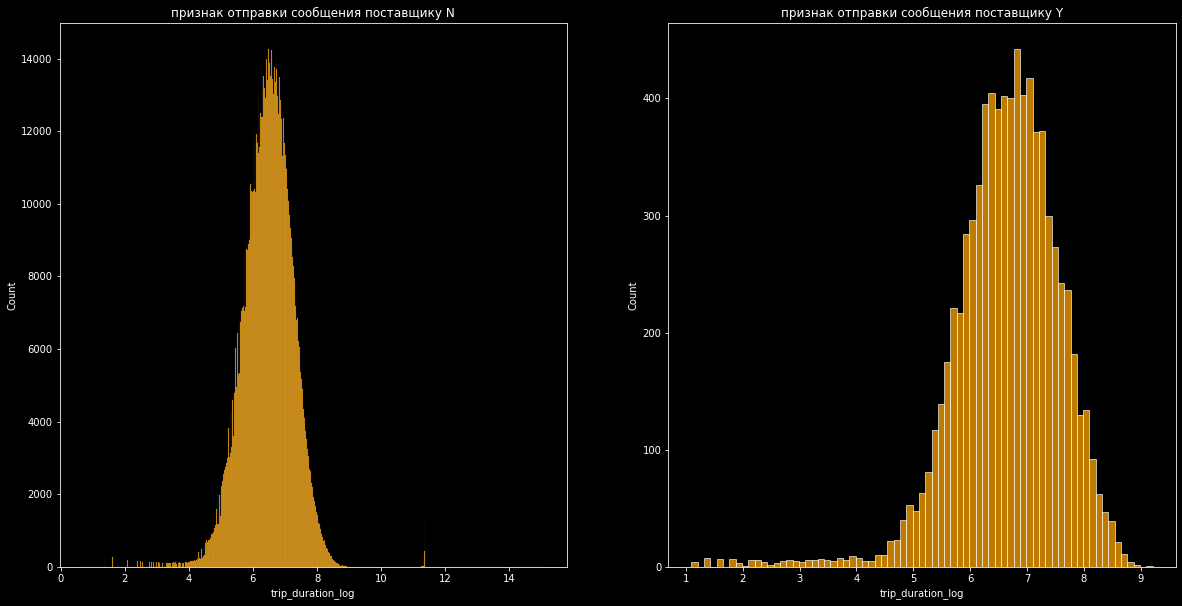

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plt.style.use('dark_background')
histplot = sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag'] == 'N']['trip_duration_log'],color='orange', ax=axes[0]);
histplot.set_title('признак отправки сообщения поставщику N');
histplot = sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']['trip_duration_log'],color='orange', ax=axes[1]);
histplot.set_title('признак отправки сообщения поставщику Y');

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

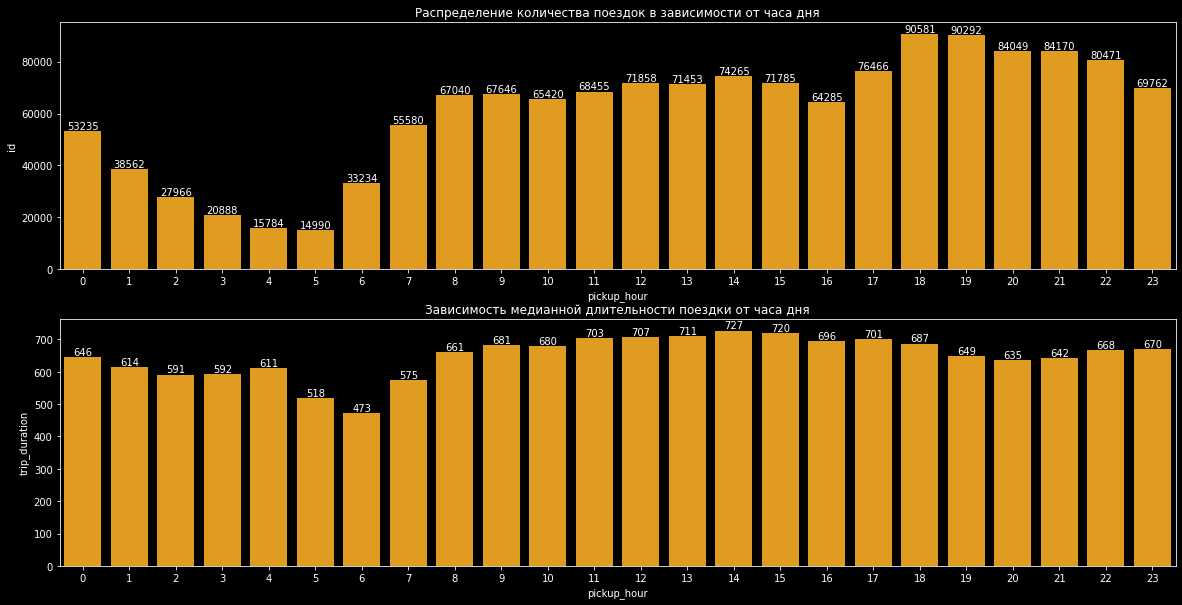

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.style.use('dark_background')
#fig = plt.figure(figsize=(15, 7))
data1 = taxi_data.groupby(by='pickup_hour', as_index=False).count();
data2 = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].median();
barplot = sns.barplot(
    data=data1,
    x=data1.iloc[:, 0],
    y=data1.iloc[:, 1],
    color='orange',
    ax=axes[0]);
barplot.set_title('Распределение количества поездок в зависимости от часа дня');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data2,
    x=data2.iloc[:, 0],
    y=data2.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от часа дня');
barplot.bar_label(barplot.containers[0]);

### На основе построенных графиков ответьте на следующие вопросы:
### а) В какое время суток такси заказывают реже всего?

## Реже всего такси вызывают в 5 часов утра

### б) В какое время суток наблюдается пик медианной длительности поездок?

## Пик медианной длительности поездок наблюдается в 14 часов

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

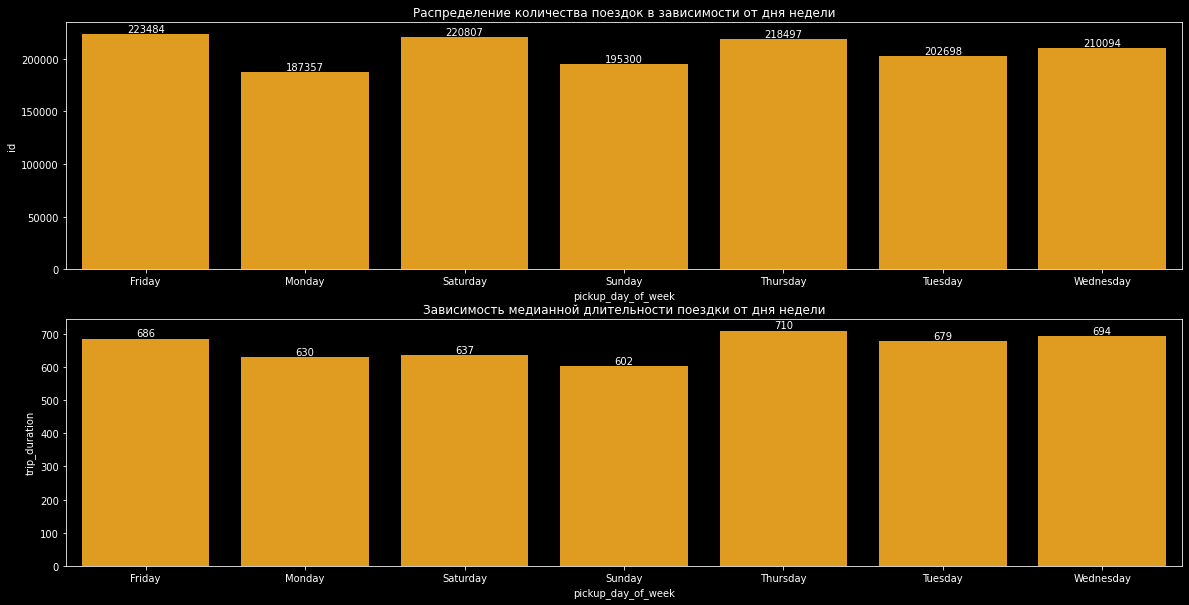

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.style.use('dark_background')
#fig = plt.figure(figsize=(15, 7))
data1 = taxi_data.groupby(by='pickup_day_of_week', as_index=False).count()
data2 = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].median()
barplot = sns.barplot(
    data=data1,
    x=data1.iloc[:, 0],
    y=data1.iloc[:, 1],
    color='orange',
    ax=axes[0])
barplot.set_title('Распределение количества поездок в зависимости от дня недели');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data2,
    x=data2.iloc[:, 0],
    y=data2.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от дня недели');
barplot.bar_label(barplot.containers[0]);



### На основе построенных графиков ответьте на следующие вопросы:
### а) В какой день недели совершается больше всего поездок?

## Friday

### б) В какой день недели медианная длительность поездок наименьшая?

## Sunday

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [64]:
trip=taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    fill_value=0,
    aggfunc='median'
)
trip

pickup_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
pickup_hour,,,,,,,
0,649.0,598,685.0,675.0,609,591.5,601.0
1,600.0,567,640.0,643.0,564,584.0,553.0
2,572.0,565,610.0,604.5,576,565.0,544.0
3,578.0,600,591.0,608.0,584,568.0,574.0
4,634.0,640,610.0,598.5,595,600.5,616.0
5,532.0,519,631.0,634.0,480,455.0,448.0
6,476.0,462,508.0,554.0,471,461.0,463.0
7,578.0,575,481.0,474.0,599,586.0,593.0
8,689.0,672,489.0,460.0,721,703.0,704.0


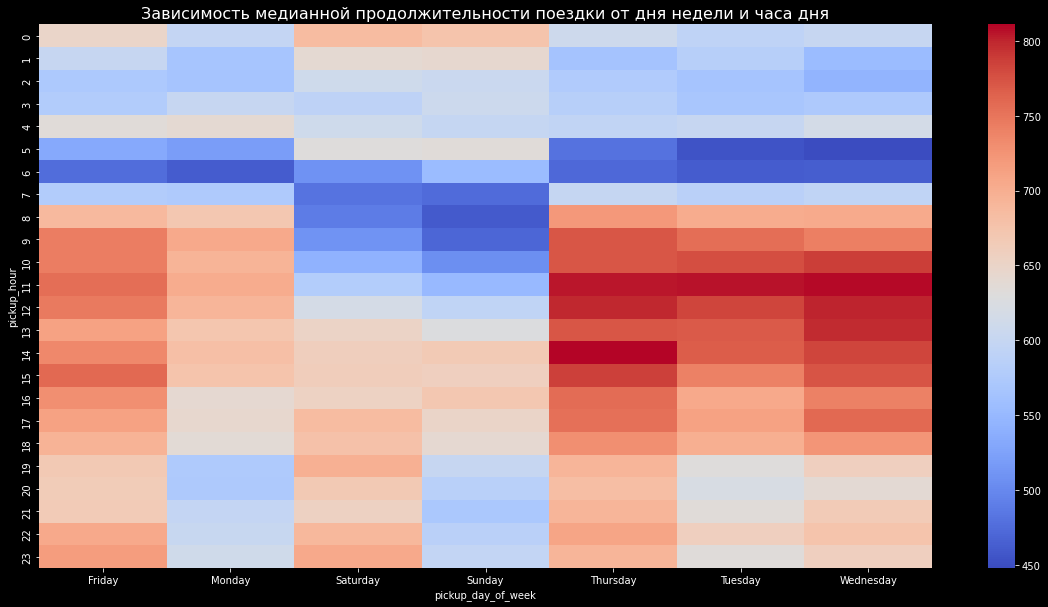

In [65]:
f, ax = plt.subplots(figsize=(20, 10))
plt.style.use('dark_background')
trip_time=sns.heatmap(data=trip,
            cmap="coolwarm");
trip_time.set_title('Зависимость медианной продолжительности поездки от дня недели и часа дня', fontsize=16);

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


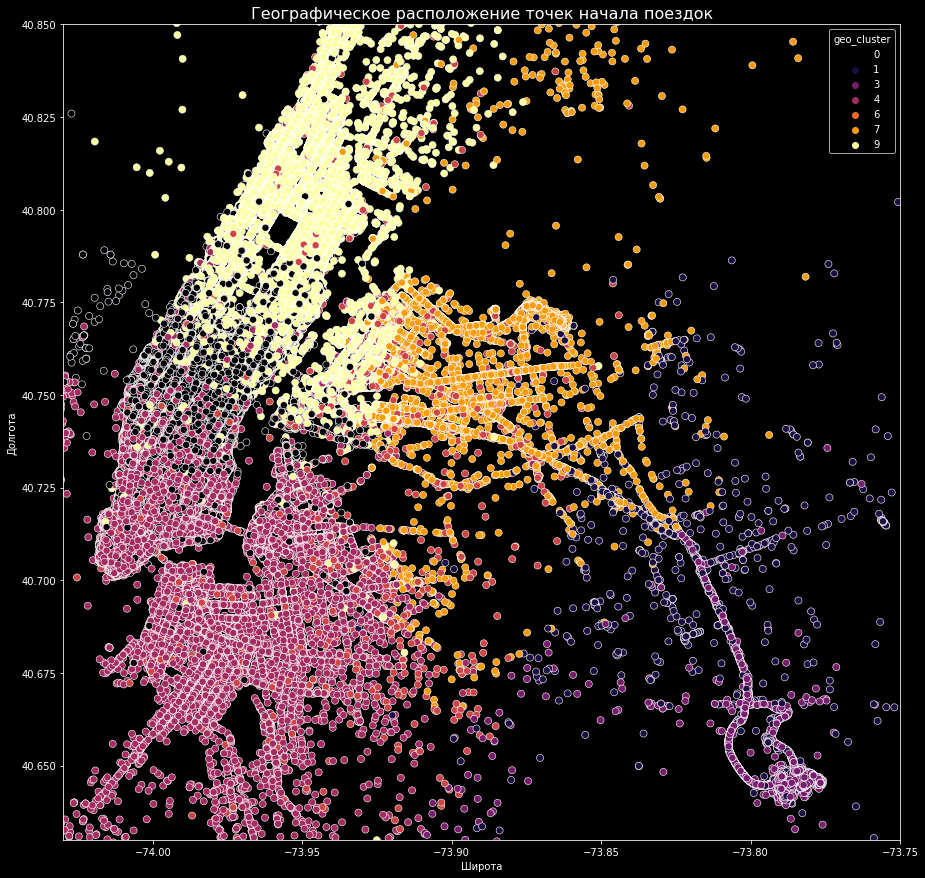

In [66]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot1 = sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    palette='inferno',
    s=50
);
scatterplot1.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot1.set_title('Географическое расположение точек начала поездок', fontsize=16);
scatterplot1.set_xlabel('Широта');
scatterplot1.set_ylabel('Долгота');


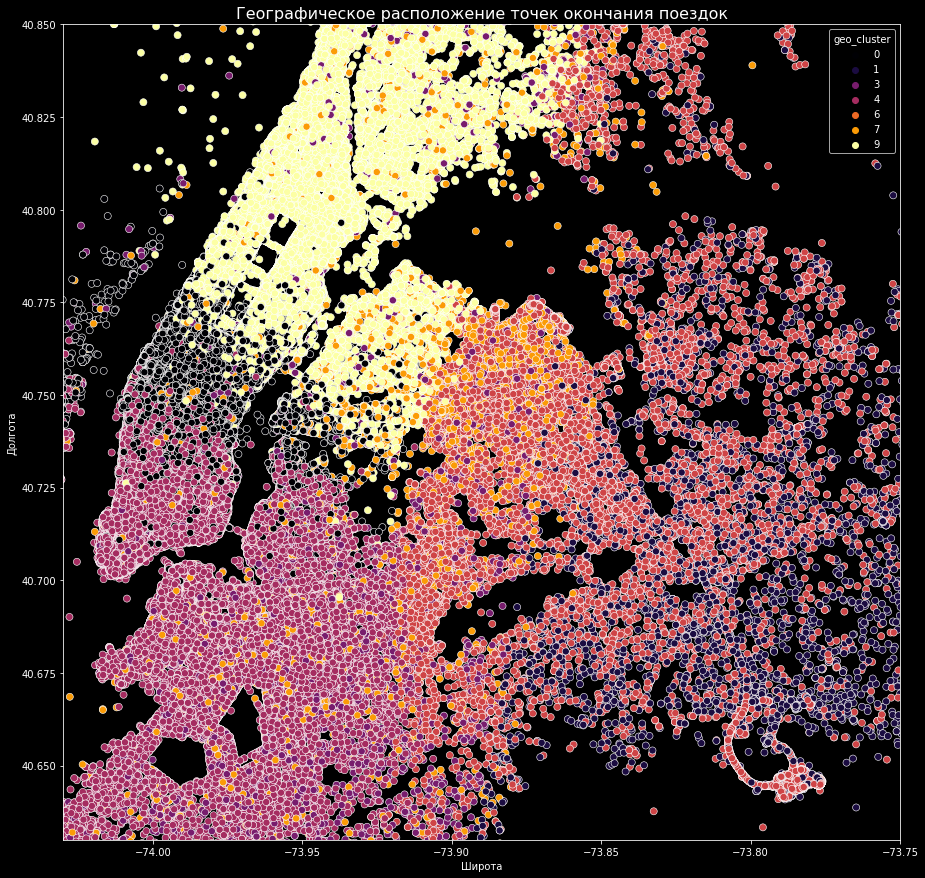

In [67]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot2 = sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='inferno',
    s=50
);
scatterplot2.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot2.set_title('Географическое расположение точек окончания поездок', fontsize=16);
scatterplot2.set_xlabel('Широта');
scatterplot2.set_ylabel('Долгота');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [68]:
print('Размер таблицы: {}'.format(taxi_data.shape))
print('Наименование столбцов таблицы: {}'.format(taxi_data.columns))

Размер таблицы: (1458237, 27)
Наименование столбцов таблицы: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [69]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


## Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

### id

б) Утечка данных (data leak) - это…

### ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

### dropoff_datetime

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?

In [70]:
train_data =train_data.drop(['id', 'dropoff_datetime'], axis=1)
print(f'Cтолбцов в таблице осталось: {len(train_data.axes[1])}')

Cтолбцов в таблице осталось: 25


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [71]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458237, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 1 в противном случае.

### а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

In [72]:
train_data['vendor_id'] = train_data['vendor_id'].astype(str)
train_data["vendor_id"] = np.where(train_data["vendor_id"].str.contains('1'), 0, 1)
print(f'Среднее по закодированному столбцу vendor_id: {round(train_data["vendor_id"].mean(),2)}')

Среднее по закодированному столбцу vendor_id: 0.53


### б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.

In [73]:
train_data["store_and_fwd_flag"] = np.where(train_data["store_and_fwd_flag"].str.contains('N'), 0, 1)
print(f'Среднее по закодированному столбцу store_and_fwd_flag: {round(train_data["store_and_fwd_flag"].mean(),3)}')

Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице train_data с помощью OneHotEndoder() из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [74]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = OneHotEncoder(drop='first')
data_onehot = encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f'Получилось сгенерировать с помощью однократного кодирования {len(data_onehot.axes[1])} бинарных столбцов')

Получилось сгенерировать с помощью однократного кодирования 18 бинарных столбцов


Добавим полученную таблицу с закодированными признаками:

In [75]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Получилась таблица с размерами: {}'.format(train_data.shape))

Получилась таблица с размерами: (1458237, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [76]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [77]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


## Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [78]:
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]


In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977018 entries, 1144842 to 121958
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     977018 non-null  int64  
 1   passenger_count               977018 non-null  int64  
 2   pickup_longitude              977018 non-null  float64
 3   pickup_latitude               977018 non-null  float64
 4   dropoff_longitude             977018 non-null  float64
 5   dropoff_latitude              977018 non-null  float64
 6   store_and_fwd_flag            977018 non-null  int64  
 7   pickup_hour                   977018 non-null  int64  
 8   pickup_holiday                977018 non-null  object 
 9   total_distance                977018 non-null  float64
 10  total_travel_time             977018 non-null  float64
 11  number_of_steps               977018 non-null  float64
 12  haversine_distance            977018 n

In [80]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481219 entries, 1251244 to 293850
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     481219 non-null  int64  
 1   passenger_count               481219 non-null  int64  
 2   pickup_longitude              481219 non-null  float64
 3   pickup_latitude               481219 non-null  float64
 4   dropoff_longitude             481219 non-null  float64
 5   dropoff_latitude              481219 non-null  float64
 6   store_and_fwd_flag            481219 non-null  int64  
 7   pickup_hour                   481219 non-null  int64  
 8   pickup_holiday                481219 non-null  object 
 9   total_distance                481219 non-null  float64
 10  total_travel_time             481219 non-null  float64
 11  number_of_steps               481219 non-null  float64
 12  haversine_distance            481219 n

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

In [136]:
scaler = preprocessing.MinMaxScaler()
 
X_train = scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_valid_scaled = scaler.transform(X_valid)

### Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.

In [82]:
print(f'Cреднее арифметическое из валидационной выборки: {round(X_valid.mean(), 2)}')
print(f'Cреднее арифметическое для первого предиктора из валидационной выборки: {X_valid[:,0].mean().round(2)}')

Cреднее арифметическое из валидационной выборки: 0.25
Cреднее арифметическое для первого предиктора из валидационной выборки: 0.53


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [83]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)
y_train_log_pred = lr.predict(X_train)
y_valid_log_pred = lr.predict(X_valid)
print('RMSLE метрика в Train выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE метрика в Valid выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE метрика в Train выборке: 0.54
RMSLE метрика в Valid выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

### а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [84]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_valid_poly = poly.transform(X_valid)

lr_poly = linear_model.LinearRegression()

lr_poly.fit(X_train_poly, y_train_log)

y_train_pred_poly = lr_poly.predict(X_train_poly)
y_valid_pred_poly = lr_poly.predict(X_valid_poly)

print('метрика RMSLE в Train выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_poly))))
print('метрика RMSLE в Valid выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly))))

метрика RMSLE в Train выборке: 0.47
метрика RMSLE в Valid выборке: 0.48


### б) Наблюдаются ли у вашей модели признаки переобучения?

### Да

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [85]:
lr_poly = Ridge(alpha=1.0)
lr_poly.fit(X_train_poly, y_train_log)
y_train_pred_poly = lr_poly.predict(X_train_poly)
y_valid_pred_poly = lr_poly.predict(X_valid_poly)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_poly))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly))))

метрика RMSLE на тренировочной выборке: 0.48
метрика RMSLE на валидационной выборке: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

### а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [86]:
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train_log)
y_train_log_pred = dt.predict(X_train)
y_valid_log_pred = dt.predict(X_valid)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке: 0.00
метрика RMSLE на валидационной выборке: 0.57


### б) Наблюдаются ли у вашей модели признаки переобучения?

### Да

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

In [87]:
param_grid = {'max_depth': range(7, 20)}
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    n_jobs = -1
)
grid_search.fit(X_train, y_train_log)
print("Оптимальная глубина дерева решений: {}".format(grid_search.best_params_))

Оптимальная глубина дерева решений: {'max_depth': 11}


### б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.

In [88]:
dtr = tree.DecisionTreeRegressor(max_depth=12)
dtr.fit(X_train, y_train_log)
y_train_log_pred = dtr.predict(X_train)
y_valid_log_pred = dtr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для дерева решений с выбранной оптимальной глубиной: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для дерева решений с выбранной оптимальной глубиной: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для дерева решений с выбранной оптимальной глубиной: 0.41
метрика RMSLE на валидационной выборке для дерева решений с выбранной оптимальной глубиной: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [89]:
rfr = RandomForestRegressor(n_estimators = 200,
                            max_depth = 12,
                            criterion = 'squared_error',
                            min_samples_split = 20,
                            random_state = 42)
rfr.fit(X_train, y_train_log)
y_train_log_pred = rfr.predict(X_train)
y_valid_log_pred = rfr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для модели случайного леса: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели случайного леса: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели случайного леса: 0.40
метрика RMSLE на валидационной выборке для модели случайного леса: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [90]:
gbr = GradientBoostingRegressor(learning_rate=0.5,
                                n_estimators=100,
                                max_depth=6,
                                min_samples_split=30,
                                random_state=42)
gbr.fit(X_train, y_train_log)
y_train_log_pred = gbr.predict(X_train)
y_valid_log_pred = gbr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 0.37
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений

### Вывод: наилучший результат показала модель "Градиентный бустинг над деревьями решений" ###


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [91]:
coef = gbr.feature_importances_
data = pd.DataFrame([coef], columns=best_features)
data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_3,geo_cluster_5,geo_cluster_7,geo_cluster_9
0,0.005621,0.000711,0.01441,0.010466,0.012742,0.029057,0.000027,0.058523,0.001286,0.630322,...,0.005482,0.00752,0.000424,0.000693,0.000658,0.0001,0.000031,0.000147,0.000242,0.000851


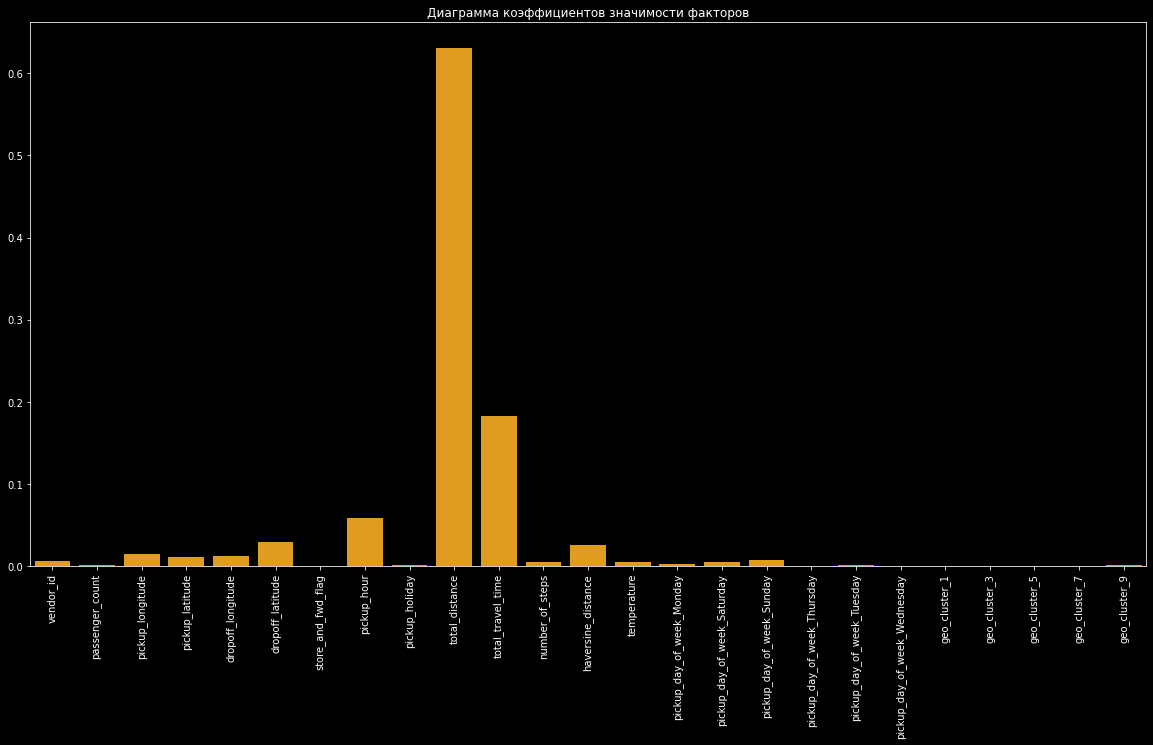

In [92]:
fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(
    data=data,color="orange")
barplot.set_title('Диаграмма коэффициентов значимости факторов')
barplot.set_xticklabels(barplot.get_xticklabels(),rotation = 90);

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [93]:
y_norm = np.exp(y_valid_log)-1
y_norm_pred = np.exp(y_valid_log_pred)-1
from sklearn.metrics import median_absolute_error
MeAE = metrics.median_absolute_error(y_norm, y_norm_pred)/60
print(f'медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: {round(MeAE, 1)}')

медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: 1.8


# Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [114]:
test_data = pd.read_csv("/kaggle/input/test-data5/Project5_test_data.csv")
osrm_data_test = pd.read_csv("/kaggle/input/osrm-data-test/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;

In [115]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')

* Добавить новые признаки (временные, географические, погодные и другие факторы);

In [116]:
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)

* Произвести очистку данных от пропусков;

In [117]:
test_data = fill_null_weather_data (test_data)

In [118]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625134 entries, 0 to 625133
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     625134 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
 9   pickup_date         625134 non-null  datetime64[ns]
 10  pickup_hour         625134 non-null  int64         
 11  pickup_day_of_week  625134 non-null  object        
 12  pickup_holiday      625134 non-null  object        
 13  total_distance      625134 no

* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;

In [119]:
one_hot_encoder = OneHotEncoder(drop='first')
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;

In [120]:
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.

In [128]:
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
y_test_log_pred = gbr.predict(X_test_scaled)
y_test_predict = np.exp(y_test_log_pred)-1

In [125]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/kaggle/working/submission_gb.csv', index=False)

In [144]:
submission

,id,trip_duration
0,id3004672,966.704613
1,id3505355,516.399630
2,id1217141,414.304429
3,id2150126,983.200222
4,id1598245,276.346760
...,...,...
625129,id3008929,354.937641
625130,id3700764,1136.722247
625131,id2568735,1883.678970
625132,id1384355,2287.348128


In [143]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [131]:
#!pip install xgboost

После чего модуль можно импортировать:

In [132]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [137]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [138]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42277	valid-rmse:5.42085
[10]	train-rmse:1.93594	valid-rmse:1.93440
[20]	train-rmse:0.78560	valid-rmse:0.78510
[30]	train-rmse:0.47958	valid-rmse:0.48078
[40]	train-rmse:0.42131	valid-rmse:0.42355
[50]	train-rmse:0.40917	valid-rmse:0.41205
[60]	train-rmse:0.40428	valid-rmse:0.40767
[70]	train-rmse:0.40134	valid-rmse:0.40503
[80]	train-rmse:0.39914	valid-rmse:0.40333
[90]	train-rmse:0.39760	valid-rmse:0.40209
[100]	train-rmse:0.39594	valid-rmse:0.40074
[110]	train-rmse:0.39449	valid-rmse:0.39956
[120]	train-rmse:0.39327	valid-rmse:0.39872
[130]	train-rmse:0.39203	valid-rmse:0.39780
[140]	train-rmse:0.39059	valid-rmse:0.39669
[150]	train-rmse:0.38950	valid-rmse:0.39597
[160]	train-rmse:0.38860	valid-rmse:0.39542
[170]	train-rmse:0.38798	valid-rmse:0.39506
[180]	train-rmse:0.38717	valid-rmse:0.39457
[190]	train-rmse:0.38668	valid-rmse:0.39425
[200]	train-rmse:0.38609	valid-rmse:0.39396
[210]	train-rmse:0.38528	valid-rmse:0.39345
[220]	train-rmse:0.38460	valid-rmse:0.39304

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [139]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39133


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

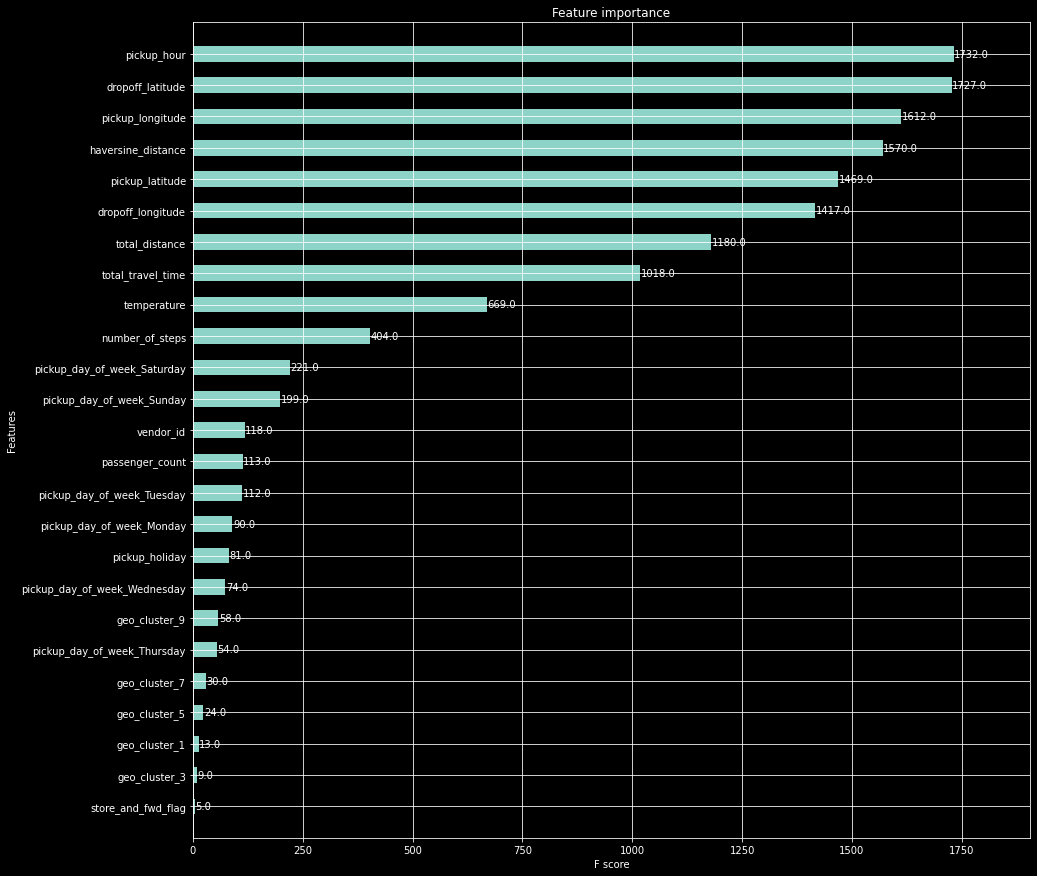

In [140]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)